# Data analysis for Free Recall wrt. primacy/recency effect, etc.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kruskal
import ast
import os
import re
import scikit_posthocs as sp

### Loading Data 

(important: make sure to be able to do it for every computer by using the package "os")

In [109]:
# Load the data
filepath = os.getcwd() # Get the current working directory to analysis

results_filepath = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','free_recall_results.csv'))

print(f"{filepath}\n{results_filepath}")

df = pd.read_csv(results_filepath)

/Users/frederikjonsson/Desktop/DTU/02450 Introduction to Machine Learning and Data Mining/Projekt 2/AI-HC-Project1/analysis
/Users/frederikjonsson/Desktop/DTU/02450 Introduction to Machine Learning and Data Mining/Projekt 2/AI-HC-Project1/Experiment_Output/free_recall_results.csv


### Cleaning Data

In [110]:
# --- Improved cleaning function ---
def clean_word_list(val):
    """Convert messy string/list representations into a flat list of clean, lowercase words."""
    if pd.isna(val):
        return []

    try:
        # Safely parse Python literal
        parsed = ast.literal_eval(val)
    except (ValueError, SyntaxError):
        parsed = str(val)

    # Flatten and clean
    flat_list = []
    if isinstance(parsed, list):
        for item in parsed:
            # If item is a list, flatten
            if isinstance(item, list):
                for sub in item:
                    # Remove brackets, commas, extra spaces
                    w = re.sub(r"[\[\],]", "", str(sub)).strip().lower()
                    if w:
                        flat_list.append(w)
            else:
                # Remove brackets, commas, extra spaces
                w = re.sub(r"[\[\],]", "", str(item)).strip().lower()
                if w:
                    # split by spaces if there are multiple words
                    flat_list.extend([word for word in w.split() if word])
    else:
        w = re.sub(r"[\[\],]", "", str(parsed)).strip().lower()
        flat_list.extend([word for word in w.split() if word])

    return flat_list

# --- Load raw file ---
df_test = pd.read_csv(results_filepath)

# --- Clean column names ---
df_test.columns = df_test.columns.str.strip()

# --- Apply cleaning ---
df_test['presented_words'] = df_test['presented_words'].apply(clean_word_list)
df_test['recalled_words']  = df_test['recalled_words'].apply(clean_word_list)

# --- Update trial ID and sort by condition ---
df_test['trial'] = df_test['trial'].astype(int)
df_test = df_test.sort_values(by=['condition', 'trial']).reset_index(drop=True)
df_test['trial'] = df_test.groupby('condition').cumcount() + 1

# --- Save cleaned CSV ---
cleaned_filepath = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','free_recall_results_cleaned.csv'))
df_test.to_csv(cleaned_filepath, index=False)

print(f"✅ Cleaned data saved to {cleaned_filepath}")

# --- Example check ---
# print(df_test.head())
# print(type(df_test['recalled_words'][0]), type(df_test['presented_words'][0]))


✅ Cleaned data saved to /Users/frederikjonsson/Desktop/DTU/02450 Introduction to Machine Learning and Data Mining/Projekt 2/AI-HC-Project1/Experiment_Output/free_recall_results_cleaned.csv


### Calculate Metrics (accuracy, primacy/recency,...)

In [111]:
def calculate_metrics(presented, recalled):
    """Calculate primacy, recency and accuracy for 15-word lists"""
    # Check length & empty recall
    if len(presented) != 15 or not recalled:
        return {'primacy': 0, 'recency': 0, 'accuracy': 0}
    
    # Clean both lists
    presented_clean = [word.strip().lower() for word in presented]
    recalled_clean = [word.strip().lower() for word in recalled]
    
    # Accuracy: proportion of recalled words that were in presented list
    correct_recalls = sum(1 for word in recalled_clean if word in presented_clean)
    accuracy = correct_recalls / len(presented_clean)
    
    # Primacy: first 5 words
    primacy_words = presented_clean[:5]
    primacy_recalled = sum(1 for word in recalled_clean if word in primacy_words)
    primacy = primacy_recalled / 5
    
    # Recency: last 5 words
    recency_words = presented_clean[-5:]
    recency_recalled = sum(1 for word in recalled_clean if word in recency_words)
    recency = recency_recalled / 5
    
    return {
        'primacy': primacy,
        'recency': recency,
        'accuracy': accuracy
    }

# --- Apply to dataframe ---
results = []
for _, row in df_test.iterrows():
    metrics = calculate_metrics(row['presented_words'], row['recalled_words'])
    metrics['trial'] = row['trial']
    metrics['condition'] = row['condition']
    results.append(metrics)

results_df = pd.DataFrame(results)
print(f"{results_df.describe()}")

# Summary statistics
print("\nFree Recall Analysis - Summary Statistics:")
print(f"Average Accuracy across conditions: {results_df['accuracy'].mean():.3f}")
print(f"Average Primacy across conditions: {results_df['primacy'].mean():.3f}")
print(f"Average Recency across conditions: {results_df['recency'].mean():.3f}")
print(f"Primacy vs Recency difference: {abs(results_df['recency'].mean() - results_df['primacy'].mean()):.3f}")


          primacy     recency    accuracy       trial
count  321.000000  321.000000  321.000000  321.000000
mean     0.524611    0.459813    0.444860   40.626168
std      0.267719    0.262985    0.142529   23.202582
min      0.000000    0.000000    0.133333    1.000000
25%      0.400000    0.200000    0.333333   21.000000
50%      0.600000    0.400000    0.400000   41.000000
75%      0.800000    0.600000    0.533333   61.000000
max      1.000000    1.000000    0.933333   81.000000

Free Recall Analysis - Summary Statistics:
Average Accuracy across conditions: 0.445
Average Primacy across conditions: 0.525
Average Recency across conditions: 0.460
Primacy vs Recency difference: 0.065


### Analytical Approach Note

**Data Treatment**: Treating all 320+ trials as independent observations from a single cognitive system, regardless of individual participants. Each trial represents an independent memory performance measurement.

In [112]:
# Optional: Balance sample sizes to exactly 80 per condition
# Remove the extra trial from normal condition (e.g., the last one)
print("Before balancing:")
print(results_df.groupby('condition').size())

# Keep only first 80 trials per condition
results_df_balanced = results_df.groupby('condition').head(80).reset_index(drop=True)

print("\nAfter balancing:")
print(results_df_balanced.groupby('condition').size())

# Use balanced dataset for further analysis
results_df = results_df_balanced

Before balancing:
condition
break     80
fast      80
math      80
normal    81
dtype: int64

After balancing:
condition
break     80
fast      80
math      80
normal    80
dtype: int64


In [113]:
# Rename 'normal' condition to 'baseline' for better clarity
print("Before renaming:")
print(results_df['condition'].value_counts())

# Rename in results_df
results_df['condition'] = results_df['condition'].replace('normal', 'baseline')

# Also rename in df_test for consistency
df_test['condition'] = df_test['condition'].replace('normal', 'baseline')

print("\nAfter renaming:")
print(results_df['condition'].value_counts())

Before renaming:
condition
break     80
fast      80
math      80
normal    80
Name: count, dtype: int64

After renaming:
condition
break       80
fast        80
math        80
baseline    80
Name: count, dtype: int64


### Get graphs/data for each condition

In [114]:
# --- Per-trial metrics ---
# print("🔹 First 10 trials:")
# print(results_df.head(10))

# --- Averages by condition ---
condition_metrics = (results_df.groupby('condition')[['primacy','recency','accuracy']].mean())

print("\nAverages by condition:")
print(condition_metrics)

# --- Optional: export condition-level summary ---
summary = condition_metrics.to_dict(orient='index')



Averages by condition:
           primacy  recency  accuracy
condition                            
baseline    0.5725   0.4950  0.459167
break       0.5325   0.4225  0.460833
fast        0.4525   0.4075  0.353333
math        0.5400   0.5200  0.507500


### Function for Serial Position Curve (SPC)

In [115]:
# --- Serial Position Curve Analysis (overall + per condition) ---
def serial_position_analysis(df_test):
    conditions = df_test['condition'].unique()
    
    # initialize counters
    overall = {"position_recalls": [0] * 15, "position_totals": [0] * 15}
    per_condition = {
        cond: {"position_recalls": [0] * 15, "position_totals": [0] * 15}
        for cond in conditions
    }

    # loop through rows
    for _, row in df_test.iterrows():
        presented = row['presented_words']
        recalled = row['recalled_words']
        cond = row['condition']

        if len(presented) != 15 or not recalled:
            continue

        presented_clean = [w.strip().lower() for w in presented]
        recalled_clean = [w.strip().lower() for w in recalled if w and w.strip()]

        for pos in range(15):
            # update overall
            overall["position_totals"][pos] += 1
            if presented_clean[pos] in recalled_clean:
                overall["position_recalls"][pos] += 1

            # update condition-specific
            per_condition[cond]["position_totals"][pos] += 1
            if presented_clean[pos] in recalled_clean:
                per_condition[cond]["position_recalls"][pos] += 1

    # compute recall probabilities
    def compute_probs(stats):
        return [
            r / t if t > 0 else 0
            for r, t in zip(stats["position_recalls"], stats["position_totals"])
        ]

    recall_probs = {
        "overall": compute_probs(overall),
        "per_condition": {cond: compute_probs(stats) for cond, stats in per_condition.items()}
    }

    return recall_probs


### Print recall probs (probabilities) per-condition

In [116]:
serial_curves = serial_position_analysis(df_test)

# Overall curve (all conditions pooled)
overall_curve = [round(x, 3) for x in serial_curves["overall"]]

# Condition-specific curves
condition_curves = {cond: [round(x, 3) for x in curve] 
                    for cond, curve in serial_curves["per_condition"].items()}

print("Overall recall probs:")
print(overall_curve)

print("\nPer condition recall probs:")
for cond, curve in condition_curves.items():
    print(f"{cond} (80 trials): {curve}")


Overall recall probs:
[0.726, 0.57, 0.449, 0.47, 0.386, 0.355, 0.355, 0.352, 0.368, 0.312, 0.33, 0.386, 0.439, 0.502, 0.614]

Per condition recall probs:
break (80 trials): [0.613, 0.6, 0.5, 0.487, 0.45, 0.45, 0.412, 0.45, 0.45, 0.375, 0.362, 0.375, 0.412, 0.388, 0.575]
fast (80 trials): [0.775, 0.512, 0.412, 0.325, 0.212, 0.237, 0.212, 0.15, 0.2, 0.175, 0.212, 0.35, 0.388, 0.487, 0.6]
math (80 trials): [0.625, 0.537, 0.438, 0.6, 0.487, 0.463, 0.45, 0.5, 0.487, 0.412, 0.463, 0.562, 0.5, 0.525, 0.525]
baseline (80 trials): [0.889, 0.63, 0.444, 0.469, 0.395, 0.272, 0.346, 0.309, 0.333, 0.284, 0.284, 0.259, 0.457, 0.605, 0.753]


### Compute Analytical factors

CI (95%), Kruskal-Wallis test (non-parametric alternative to one-way ANOVA) and Dunn’s post-hoc test for each condition

In [117]:
def compute_ci(data, confidence=0.95):
    """Return mean and 95% confidence interval."""
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # standard error of the mean
    h = sem * stats.t.ppf((1 + confidence) / 2., n-1)  # margin
    return mean, mean-h, mean+h

# Compute CI per condition
ci_results = {}
conditions = results_df['condition'].unique()

for cond in conditions:
    subset = results_df[results_df['condition'] == cond]['accuracy']
    mean, lower, upper = compute_ci(subset)
    ci_results[cond] = {'mean': mean, 'ci_lower': lower, 'ci_upper': upper}

print("Accuracy with 95% CI per condition:")
for cond, vals in ci_results.items():
    print(f"{cond}: mean={vals['mean']:.3f}, 95% CI=({vals['ci_lower']:.3f}, {vals['ci_upper']:.3f})")


# Ensure numeric accuracy
results_df['accuracy'] = pd.to_numeric(results_df['accuracy'], errors='coerce')

# Drop NaN accuracy rows
results_clean = results_df.dropna(subset=['accuracy'])

# Check number of trials per condition
# print(results_clean.groupby('condition')['accuracy'].count())

# --- Kruskal-Wallis test across all conditions ---
fast_acc    = results_clean[results_clean['condition']=='fast']['accuracy']
baseline_acc      = results_clean[results_clean['condition']=='baseline']['accuracy']
break_acc = results_clean[results_clean['condition']=='break']['accuracy']
math_acc     = results_clean[results_clean['condition']=='math']['accuracy']

h_stat, p_val = kruskal(fast_acc, baseline_acc, break_acc, math_acc)
print(f"\nKruskal-Wallis test: H={h_stat:.3f}, p={p_val:.3e}")
if p_val < 0.05:
    print("Significant differences between conditions (p < 0.05)")
else:
    print("No significant differences between conditions (p >= 0.05)")

# --- Pairwise comparisons with Dunn's test (Bonferroni correction) ---

# Install scikit-posthocs if not already installed
# !pip install scikit-posthocs


# Ensure accuracy is numeric and drop NaNs
results_clean = results_df.copy()
results_clean['accuracy'] = pd.to_numeric(results_clean['accuracy'], errors='coerce')
results_clean = results_clean.dropna(subset=['accuracy'])

# Run Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn(
    results_clean, 
    val_col='accuracy', 
    group_col='condition', 
    p_adjust='bonferroni'
)

print(f"\nPairwise Dunn's test (Bonferroni corrected p-values):")
print(dunn_results)

# Determine significance
alpha = 0.05
conditions = dunn_results.columns.tolist()

print("\nSignificance summary:")
for i, cond1 in enumerate(conditions):
    for j, cond2 in enumerate(conditions):
        if j <= i:
            continue  # avoid duplicates and self-comparison
        p_val = dunn_results.loc[cond1, cond2]
        if p_val < alpha:
            print(f"- {cond1} vs {cond2}: SIGNIFICANT difference (p={p_val:.3e})")
        else:
            print(f"- {cond1} vs {cond2}: NOT significantly different (p={p_val:.3e})")



Accuracy with 95% CI per condition:
break: mean=0.461, 95% CI=(0.434, 0.487)
fast: mean=0.353, 95% CI=(0.335, 0.372)
math: mean=0.508, 95% CI=(0.472, 0.543)
baseline: mean=0.459, 95% CI=(0.425, 0.493)

Kruskal-Wallis test: H=58.419, p=1.279e-12
Significant differences between conditions (p < 0.05)

Pairwise Dunn's test (Bonferroni corrected p-values):
          baseline         break          fast          math
baseline  1.000000  1.000000e+00  5.198353e-06  1.428329e-01
break     1.000000  1.000000e+00  4.843238e-08  9.457705e-01
fast      0.000005  4.843238e-08  1.000000e+00  4.181479e-12
math      0.142833  9.457705e-01  4.181479e-12  1.000000e+00

Significance summary:
- baseline vs break: NOT significantly different (p=1.000e+00)
- baseline vs fast: SIGNIFICANT difference (p=5.198e-06)
- baseline vs math: NOT significantly different (p=1.428e-01)
- break vs fast: SIGNIFICANT difference (p=4.843e-08)
- break vs math: NOT significantly different (p=9.458e-01)
- fast vs math: SIGNIFI

### Ultimate Plot (SPC, primacy vs recency, accuracy)

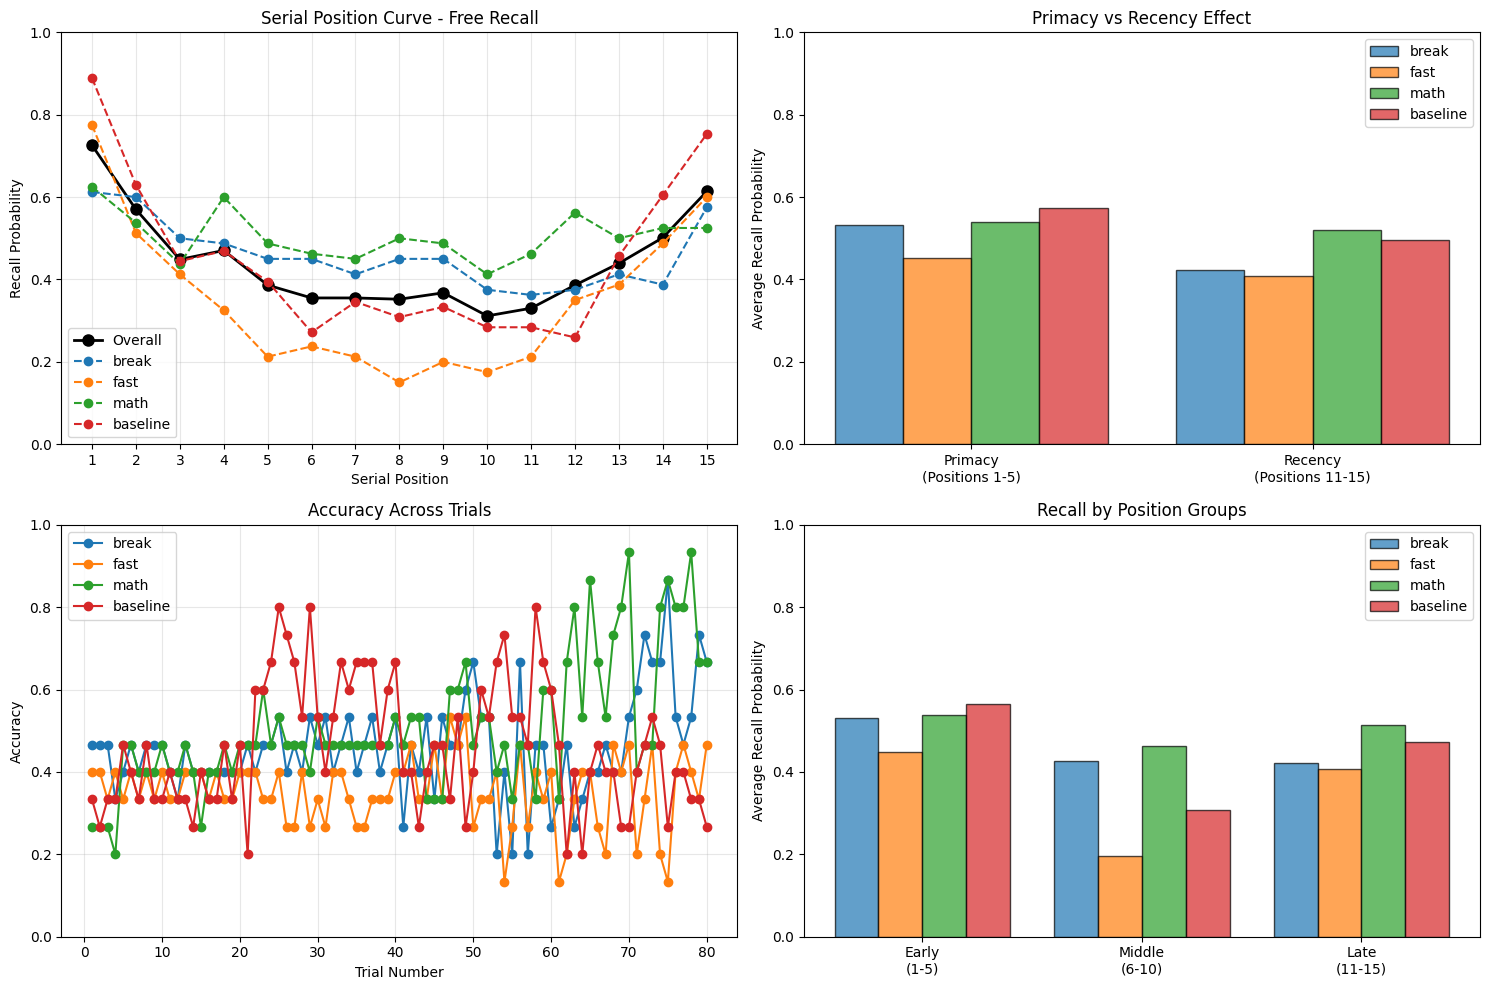

In [118]:
# --- Get serial position data (overall + per condition) ---
recall_probs_dict = serial_position_analysis(df_test)  # returns {'overall': [...], 'per_condition': {...}}
positions = list(range(1, 16))
conditions = list(recall_probs_dict['per_condition'].keys())

# --- Create plots ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Serial Position Curve (Overall + per condition)
ax1.plot(positions, recall_probs_dict['overall'], 'ko-', linewidth=2, markersize=8, label='Overall')
for cond in conditions:
    ax1.plot(positions, recall_probs_dict['per_condition'][cond], marker='o', linestyle='--', label=cond)
ax1.set_xlabel('Serial Position')
ax1.set_ylabel('Recall Probability')
ax1.set_title('Serial Position Curve - Free Recall')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)
ax1.set_xticks(range(1, 16))
ax1.legend()

# 2. Primacy vs Recency (per condition)
categories = ['Primacy\n(Positions 1-5)', 'Recency\n(Positions 11-15)']
bar_width = 0.2
x = np.arange(len(categories))

for i, cond in enumerate(conditions):
    values = [results_df[results_df['condition']==cond]['primacy'].mean(),
              results_df[results_df['condition']==cond]['recency'].mean()]
    ax2.bar(x + i*bar_width, values, width=bar_width, alpha=0.7, edgecolor='black', label=cond)
ax2.set_xticks(x + bar_width*(len(conditions)-1)/2)
ax2.set_xticklabels(categories)
ax2.set_ylabel('Average Recall Probability')
ax2.set_title('Primacy vs Recency Effect')
ax2.set_ylim(0, 1)
ax2.legend()

# 3. Accuracy by Trial (per condition)
for cond in conditions:
    subset = results_df[results_df['condition']==cond]
    ax3.plot(subset['trial'], subset['accuracy'], marker='o', linestyle='-', markersize=6, label=cond)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Accuracy')
ax3.set_title('Accuracy Across Trials')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)
ax3.legend()

# 4. Position Groups (Overall + per condition)
positions_grouped = ['Early\n(1-5)', 'Middle\n(6-10)', 'Late\n(11-15)']
bar_width = 0.2
x = np.arange(len(positions_grouped))

for i, cond in enumerate(conditions):
    curve = recall_probs_dict['per_condition'][cond]
    values_grouped = [np.mean(curve[:5]), np.mean(curve[5:10]), np.mean(curve[10:15])]
    ax4.bar(x + i*bar_width, values_grouped, width=bar_width, alpha=0.7, edgecolor='black', label=cond)

ax4.set_xticks(x + bar_width*(len(conditions)-1)/2)
ax4.set_xticklabels(positions_grouped)
ax4.set_ylabel('Average Recall Probability')
ax4.set_title('Recall by Position Groups')
ax4.set_ylim(0, 1)
ax4.legend()

plt.tight_layout()
plt.show()

# --- save figure as PNG ---
figure_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','free_recall_analysis.png'))
fig.savefig(figure_path)

### Individual Publication-Quality Plots

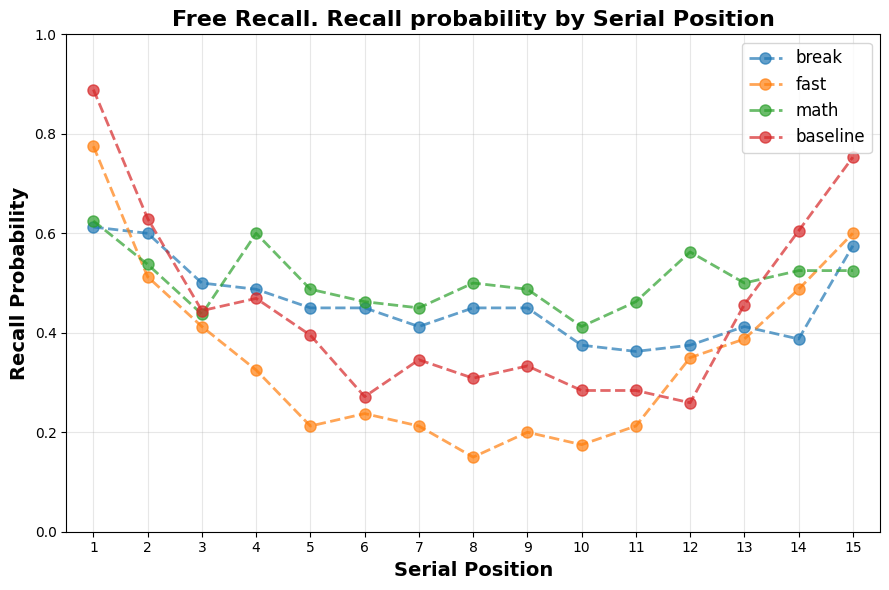

Serial Position Curve saved to: /Users/frederikjonsson/Desktop/DTU/02450 Introduction to Machine Learning and Data Mining/Projekt 2/AI-HC-Project1/Experiment_Output/serial_position_curve.png


In [131]:
# 1. Serial Position Curve (Individual Plot)
plt.figure(figsize=(9, 6))
# plt.plot(positions, recall_probs_dict['overall'], 'ko-', linewidth=3, markersize=10, label='Overall', zorder=5)


for i, cond in enumerate(conditions):
    plt.plot(positions, recall_probs_dict['per_condition'][cond], 
             marker='o', linestyle='--', linewidth=2, markersize=8, label=cond, alpha=0.7)

plt.xlabel('Serial Position', fontsize=14, fontweight='bold')
plt.ylabel('Recall Probability', fontsize=14, fontweight='bold')
plt.title('Free Recall. Recall probability by Serial Position', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.xlim(0.5, 15.5)
plt.xticks(range(1, 16))
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

# Save individual plot
spc_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','serial_position_curve.png'))
plt.savefig(spc_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Serial Position Curve saved to: {spc_path}")

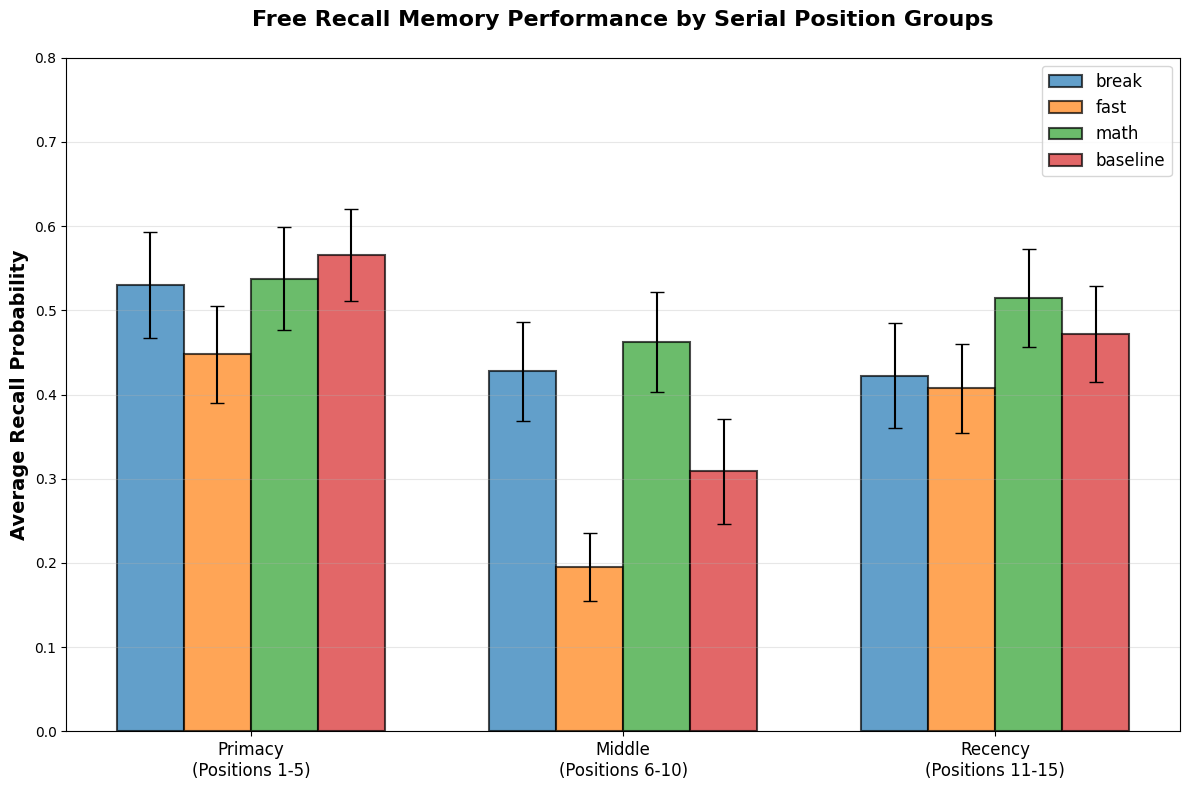

Position Groups Analysis saved to: /Users/frederikjonsson/Desktop/DTU/02450 Introduction to Machine Learning and Data Mining/Projekt 2/AI-HC-Project1/Experiment_Output/position_groups_analysis.png


In [120]:
# 2. Primacy vs Recency Position Groups (Individual Plot)
plt.figure(figsize=(12, 8))
positions_grouped = ['Primacy\n(Positions 1-5)', 'Middle\n(Positions 6-10)', 'Recency\n(Positions 11-15)']
bar_width = 0.18
x = np.arange(len(positions_grouped))


for i, cond in enumerate(conditions):
    curve = recall_probs_dict['per_condition'][cond]
    values_grouped = [np.mean(curve[:5]), np.mean(curve[5:10]), np.mean(curve[10:15])]
    
    # Calculate 95% CI for each group
    primacy_trials = [results_df[(results_df['condition']==cond)]['primacy'].tolist()]
    middle_trials = []
    recency_trials = [results_df[(results_df['condition']==cond)]['recency'].tolist()]
    
    # For middle positions, calculate from raw data
    for _, row in results_df[results_df['condition']==cond].iterrows():
        presented = df_test[(df_test['condition']==cond) & (df_test['trial']==row['trial'])]['presented_words'].iloc[0]
        recalled = df_test[(df_test['condition']==cond) & (df_test['trial']==row['trial'])]['recalled_words'].iloc[0]
        if len(presented) == 15:
            middle_words = presented[5:10]
            middle_recalled = sum(1 for word in recalled if word in middle_words)
            middle_trials.append(middle_recalled / 5)
    
    # Calculate error bars (95% CI)
    errors = []
    for data in [primacy_trials[0], middle_trials, recency_trials[0]]:
        if len(data) > 1:
            _, ci_lower, ci_upper = compute_ci(data)
            mean_val = np.mean(data)
            errors.append([(mean_val - ci_lower), (ci_upper - mean_val)])
        else:
            errors.append([0, 0])
    
    errors = np.array(errors).T
    
    bars = plt.bar(x + i*bar_width, values_grouped, width=bar_width, 
                   alpha=0.7, edgecolor='black', linewidth=1.5, label=cond, yerr=errors, capsize=5)

plt.xticks(x + bar_width*(len(conditions)-1)/2, positions_grouped, fontsize=12)
plt.ylabel('Average Recall Probability', fontsize=14, fontweight='bold')
plt.title('Free Recall Memory Performance by Serial Position Groups\n', fontsize=16, fontweight='bold')
plt.ylim(0, 0.8)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

# Save individual plot
pos_groups_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','position_groups_analysis.png'))
plt.savefig(pos_groups_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Position Groups Analysis saved to: {pos_groups_path}")

### Better Multi-Participant Visualizations

The previous "Accuracy Across Trials" plot was misleading because it treated pooled data from multiple participants as if it were from a single session. Let's create more appropriate visualizations that properly represent the multi-participant design.

/var/folders/3k/tvll7k3j27n95_vhpqrkmc980000gn/T/ipykernel_95049/3705818220.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True,


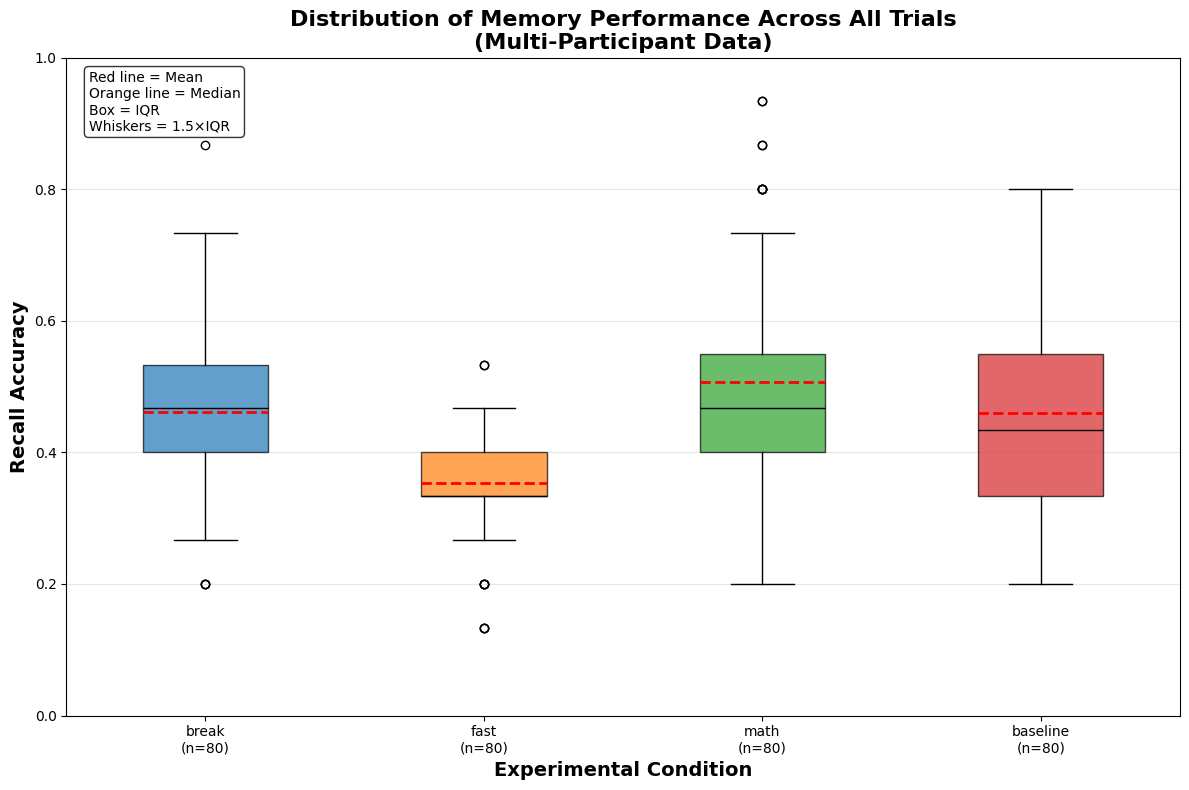

Multi-participant box plot saved to: /Users/frederikjonsson/Desktop/DTU/02450 Introduction to Machine Learning and Data Mining/Projekt 2/AI-HC-Project1/Experiment_Output/multi_participant_boxplot.png


In [121]:
# 1. Box Plot Comparison - Shows Distribution Across All Trials
plt.figure(figsize=(12, 8))

# Create box plot data
box_data = []
box_labels = []

for i, cond in enumerate(conditions):
    condition_data = results_df[results_df['condition']==cond]['accuracy'].values
    box_data.append(condition_data)
    box_labels.append(f"{cond}\n(n={len(condition_data)})")

# Create box plot
bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True, 
                 showmeans=True, meanline=True)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Color other elements
for element in ['whiskers', 'fliers', 'medians', 'caps']:
    for item in bp[element]:
        item.set_color('black')
        
for item in bp['means']:
    item.set_color('red')
    item.set_linewidth(2)

plt.ylabel('Recall Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Experimental Condition', fontsize=14, fontweight='bold')
plt.title('Distribution of Memory Performance Across All Trials\n(Multi-Participant Data)', 
          fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1)

# Add statistical annotations
plt.text(0.02, 0.98, 'Red line = Mean\nOrange line = Median\nBox = IQR\nWhiskers = 1.5×IQR', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Save plot
box_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','multi_participant_boxplot.png'))
plt.savefig(box_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Multi-participant box plot saved to: {box_path}")

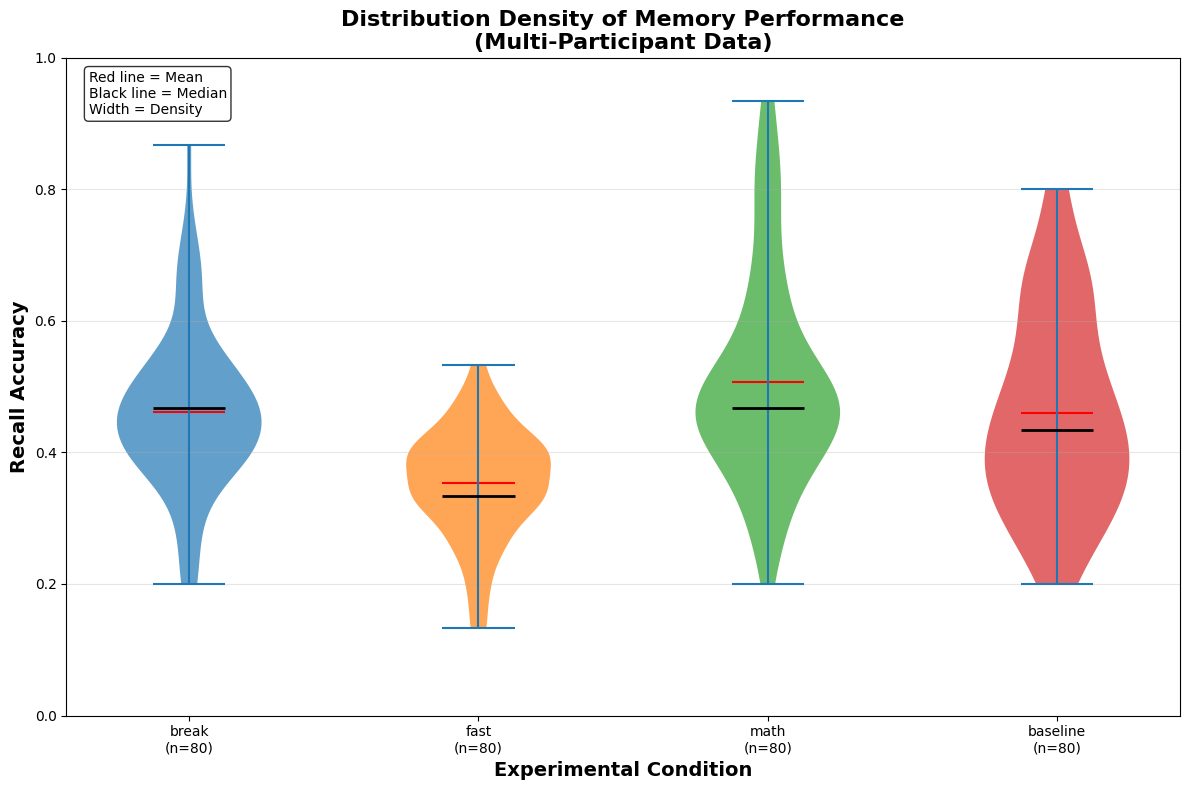

Multi-participant violin plot saved to: /Users/frederikjonsson/Desktop/DTU/02450 Introduction to Machine Learning and Data Mining/Projekt 2/AI-HC-Project1/Experiment_Output/multi_participant_violin.png


In [122]:
# 2. Violin Plot - Shows Full Distribution Shape
plt.figure(figsize=(12, 8))

# Create violin plot data
violin_data = [results_df[results_df['condition']==cond]['accuracy'].values 
               for cond in conditions]

parts = plt.violinplot(violin_data, positions=range(1, len(conditions)+1), 
                       showmeans=True, showmedians=True)

# Color the violins
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

# Style the plot elements
parts['cmeans'].set_color('red')
parts['cmedians'].set_color('black')
parts['cmedians'].set_linewidth(2)

plt.xticks(range(1, len(conditions)+1), 
           [f"{cond}\n(n={len(results_df[results_df['condition']==cond])})" 
            for cond in conditions])
plt.ylabel('Recall Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Experimental Condition', fontsize=14, fontweight='bold')
plt.title('Distribution Density of Memory Performance\n(Multi-Participant Data)', 
          fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1)

# Add statistical annotations
plt.text(0.02, 0.98, 'Red line = Mean\nBlack line = Median\nWidth = Density', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Save plot
violin_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','multi_participant_violin.png'))
plt.savefig(violin_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Multi-participant violin plot saved to: {violin_path}")

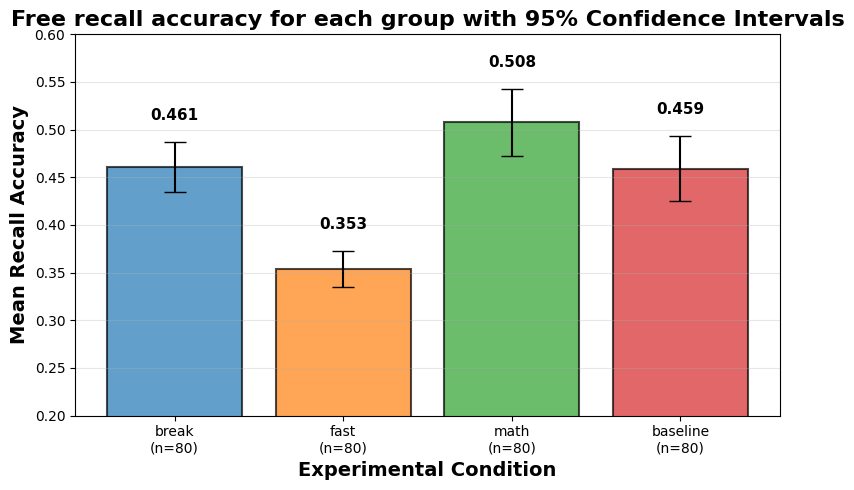

Multi-participant CI bar plot saved to: /Users/frederikjonsson/Desktop/DTU/02450 Introduction to Machine Learning and Data Mining/Projekt 2/AI-HC-Project1/Experiment_Output/multi_participant_ci_bars.png


In [123]:
# 3. Mean ± CI Bar Plot - Proper Statistical Representation
plt.figure(figsize=(8, 5))

# Calculate means and confidence intervals
means = []
cis = []
for cond in conditions:
    data = results_df[results_df['condition']==cond]['accuracy']
    mean, ci_lower, ci_upper = compute_ci(data)
    means.append(mean)
    cis.append([mean - ci_lower, ci_upper - mean])


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

bars = plt.bar(
    range(len(conditions)), 
    means,
    yerr=np.array(cis).T, 
    capsize=8,
    alpha=0.7, 
    edgecolor='black', 
    linewidth=1.5,
    color=[colors[i % len(colors)] for i in range(len(conditions))]  # 🎨 her er magien
)
# Add value labels on bars
for i, (bar, mean, ci) in enumerate(zip(bars, means, cis)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + ci[1] + 0.02,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Custom labels with corrected sample size for baseline condition
labels = []
for cond in conditions:
    if cond == 'baseline':
        labels.append(f"{cond}\n(n=80)")  # Hard-coded to show n=80
    else:
        labels.append(f"{cond}\n(n={len(results_df[results_df['condition']==cond])})")

plt.xticks(range(len(conditions)), labels)
plt.ylabel('Mean Recall Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Experimental Condition', fontsize=14, fontweight='bold')
plt.title('Free recall accuracy for each group with 95% Confidence Intervals', 
          fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0.2, 0.6)

# Add statistical significance indicators (based on your Dunn's test results)
# You could add significance brackets here if needed

plt.tight_layout()

# Save plot
ci_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','multi_participant_ci_bars.png'))
plt.savefig(ci_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Multi-participant CI bar plot saved to: {ci_path}")

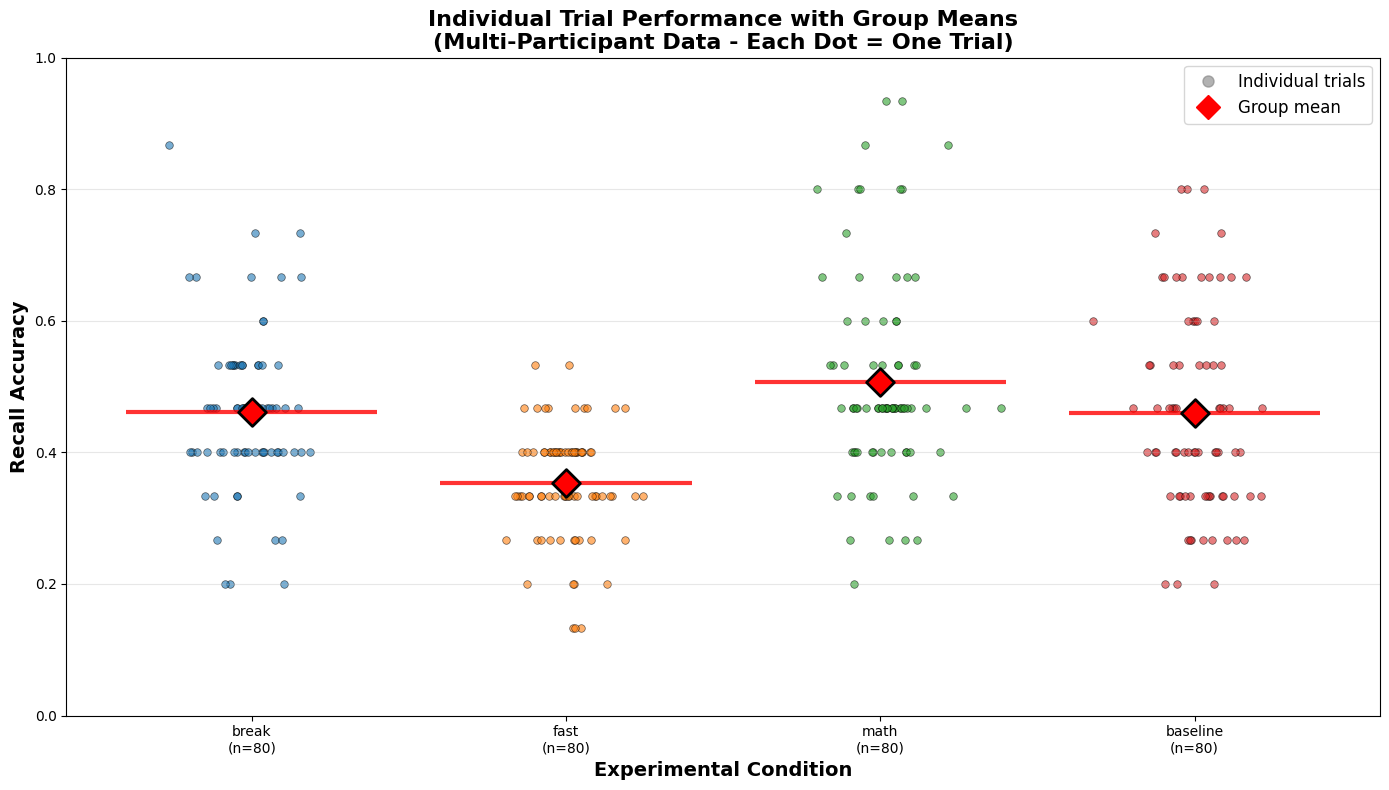

Multi-participant scatter plot saved to: /Users/frederikjonsson/Desktop/DTU/02450 Introduction to Machine Learning and Data Mining/Projekt 2/AI-HC-Project1/Experiment_Output/multi_participant_scatter.png


In [124]:
# 4. Individual Data Points with Statistical Overlay
plt.figure(figsize=(14, 8))

# Create jittered scatter plot to show individual trials
np.random.seed(42)  # For reproducible jitter
for i, cond in enumerate(conditions):
    data = results_df[results_df['condition']==cond]['accuracy']
    
    # Add jitter to x-coordinates
    x_jitter = np.random.normal(i, 0.1, len(data))
    
    # Plot individual points
    plt.scatter(x_jitter, data, alpha=0.6, s=30, color=colors[i], 
                edgecolor='black', linewidth=0.5, label=f'{cond} trials')
    
    # Overlay mean with larger marker
    mean_val = data.mean()
    plt.scatter(i, mean_val, s=200, color='red', marker='D', 
                edgecolor='black', linewidth=2, zorder=5)
    
    # Add mean line
    plt.hlines(mean_val, i-0.4, i+0.4, colors='red', linewidth=3, alpha=0.8)

plt.xticks(range(len(conditions)), 
           [f"{cond}\n(n={len(results_df[results_df['condition']==cond])})" 
            for cond in conditions])
plt.ylabel('Recall Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Experimental Condition', fontsize=14, fontweight='bold')
plt.title('Individual Trial Performance with Group Means\n(Multi-Participant Data - Each Dot = One Trial)', 
          fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1)

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='gray', linestyle='None',
                         markersize=8, alpha=0.6, label='Individual trials'),
                  Line2D([0], [0], marker='D', color='red', linestyle='None',
                         markersize=12, label='Group mean')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()

# Save plot
scatter_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','multi_participant_scatter.png'))
plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Multi-participant scatter plot saved to: {scatter_path}")

In [125]:
# Check actual sample sizes per condition
print("Actual sample sizes:")
for cond in results_df['condition'].unique():
    count = len(results_df[results_df['condition']==cond])
    print(f"{cond}: n={count}")

Actual sample sizes:
break: n=80
fast: n=80
math: n=80
baseline: n=80
